In [1]:
cd ../..

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/lfs/rambo/0/adobles/relbench-user-study


## Feature Ideas

- `price`
- `category`
- `title`: Embedding
- `num_reviews`
- `sum_ratings`
- `avg_rating`
- `std_rating`
- `min_rating`
- `max_rating`
- `avg_review_length`
- `weeks_since_first_review`
- `weeks_since_median_review`
- `weeks_since_latest_review`
- `last_review_summary`: Embedding
- `last_review_is_verified`
- `pct_verified_reviews`
- `product_bias`: avg_rating - global_avg_rating / global_std_rating
- reviewer aggs:
    - `avg_reviewer_total_spent`
    - `avg_reviewer_num_reviews`
    - `avg_reviewer_avg_price`
    - `avg_reviewer_avg_rating`
    - `avg_reviewer_std_rating`
- trend stuff: avg value in last 6 months - avg value in previous 6 month window
    - `num_reviews_trend`
    - `avg_rating_trend`
    - `avg_price_trend`
    - `sum_price_trend`
    - `product_bias_trend`

Note: related product features would scale quadratically, likely too expensive/complex. For this
reason I have omitted them.

In [3]:
import duckdb
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('amazon/amazon.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

In [53]:
with open('amazon/product-churn/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
# takes 1 - 5 mins
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s, subsample=1_000_000))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [5]:
utils.validate_feature_tables('product_churn', conn)

Validating train
train labels size: 2,559,264 x 3
train feats size: 1,000,000 x 31
⚠️ 1,559,264 samples are missing from feats table!

Validating val
val labels size: 177,689 x 3
val feats size: 177,689 x 31

Validating test
test labels size: 166,842 x 2
test feats size: 166,842 x 30

❌ 1 errors found!


^-- Failure expected bc of subsampling

In [6]:
%%sql train_df <<
from product_churn_train_feats

In [7]:
infer_df_stype(train_df)

{'product_id': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'churn': <stype.categorical: 'categorical'>,
 'price': <stype.numerical: 'numerical'>,
 'category': <stype.text_embedded: 'text_embedded'>,
 'title': <stype.text_embedded: 'text_embedded'>,
 'weeks_since_first_review': <stype.numerical: 'numerical'>,
 'weeks_since_median_review': <stype.numerical: 'numerical'>,
 'weeks_since_latest_review': <stype.numerical: 'numerical'>,
 'num_reviews': <stype.numerical: 'numerical'>,
 'sum_ratings': <stype.numerical: 'numerical'>,
 'avg_rating': <stype.numerical: 'numerical'>,
 'std_rating': <stype.numerical: 'numerical'>,
 'min_rating': <stype.categorical: 'categorical'>,
 'max_rating': <stype.categorical: 'categorical'>,
 'pct_verified_reviews': <stype.numerical: 'numerical'>,
 'avg_review_length': <stype.numerical: 'numerical'>,
 'last_review_summary': <stype.text_embedded: 'text_embedded'>,
 'product_bias': <stype.numerical: 'numerical'>,
 'avg_reviewer_

In [8]:
utils.feature_summary_df(train_df.sample(20_000), 'churn', classification=True)

,Label Corr.,Label MI,NaN %
num_reviews_trend,-0.035,0.099,0.0%
sum_ratings,-0.133,0.097,0.2%
num_reviews,-0.139,0.094,0.0%
pct_verified_reviews,-0.101,0.082,0.2%
product_bias_trend,0.002,0.079,41.7%
avg_rating_trend,0.002,0.078,41.7%
product_bias,-0.024,0.071,0.2%
std_rating,-0.024,0.068,4.6%
avg_rating,-0.024,0.065,0.2%
sum_ratings_trend,0.013,0.064,41.7%


## Feature Importances

In [9]:
import numpy as np
import shap
from torch_frame import TaskType, stype
from torch_frame.data import Dataset
from torch_frame.gbdt import LightGBM

from inferred_stypes import task_to_stypes
from train_gbdt import TASK_PARAMS

TASK = 'rel-amazon-product-churn'

task_params = TASK_PARAMS[TASK]

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
%%sql val_df <<
select * from product_churn_val_feats;

In [12]:
col_to_stype = task_to_stypes[TASK].copy()
del col_to_stype['title']
del col_to_stype['last_review_summary']
val_tf = Dataset(
    val_df,
    col_to_stype=col_to_stype,
    target_col=task_params['target_col'],
).materialize().tensor_frame

In [13]:
gbdt = LightGBM(task_type=task_params['task_type'])
gbdt.load(f'models/{TASK}_lgbm.json')
pred = gbdt.predict(tf_test=val_tf).numpy()

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


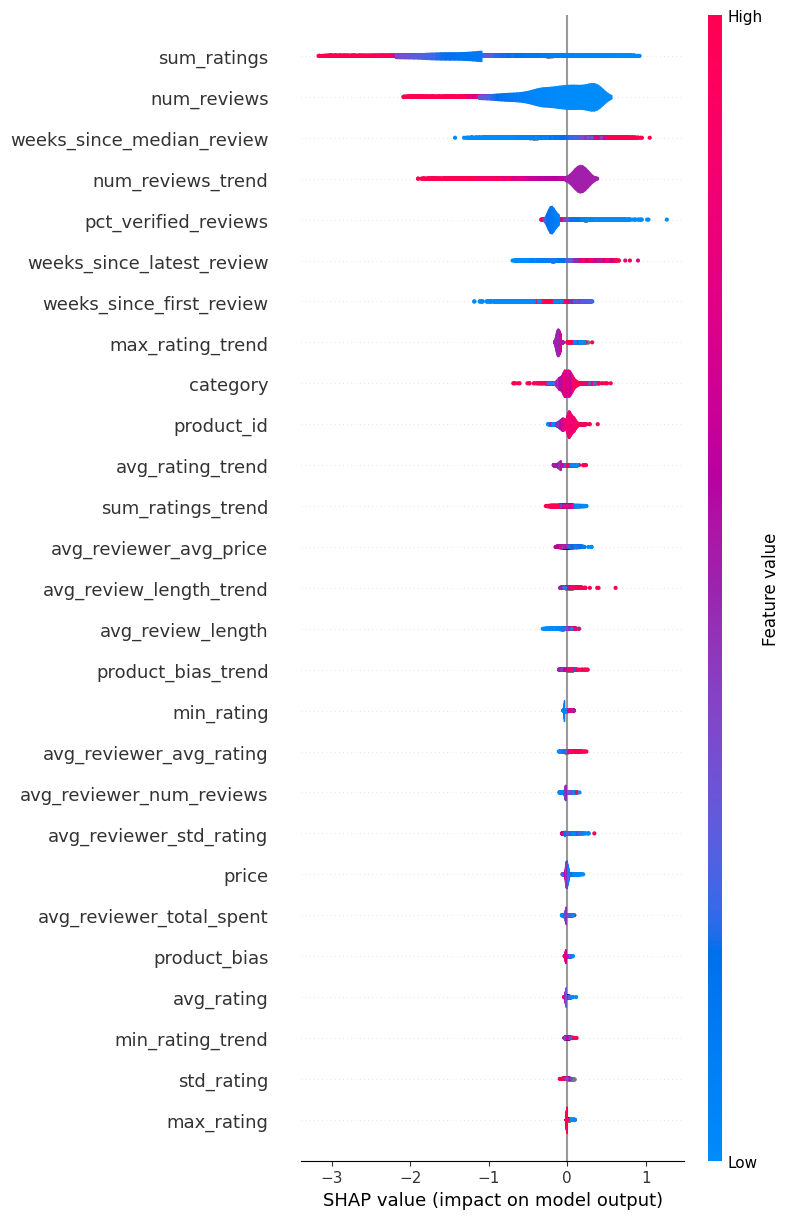

In [14]:
shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

sample = np.random.randint(0, len(val_tf), size=10_000)

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[sample])
shap_values = explainer.shap_values(val_arr, pred[sample])

# TODO verify
feat_names = val_tf.col_names_dict.get(stype.categorical, []) + val_tf.col_names_dict[stype.numerical]

shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=30, feature_names=feat_names)

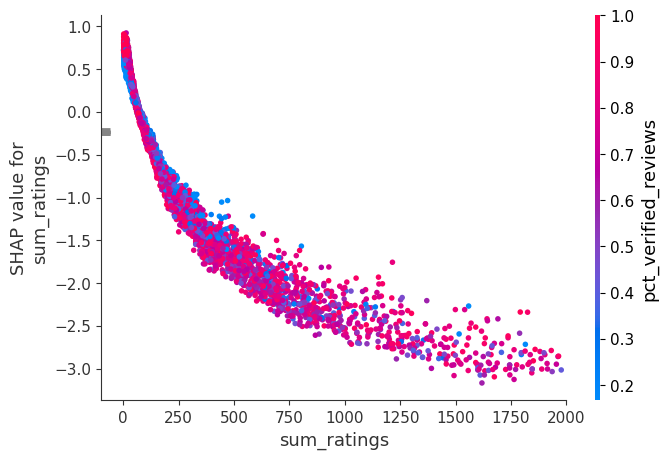

In [17]:
shap.dependence_plot('sum_ratings', shap_values, val_arr, feature_names=feat_names, xmax=2_000)

In [18]:
conn.close()